# `Splatter` Simulated Datasets
C. Heiser, 2020

---
__The purpose of this notebook is to evaluate our structural preservation metrics on a synthetic dataset of known high-dimensional structure, using simulation parameters to define global structure and compare to our metric.__  

To benchmark these techniques, we are using a [**Splatter**](https://github.com/Oshlack/splatter) simulation

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [3]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

In [4]:
# create dictionary for dumping results into
final_distance_stats = {1000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}},
                        5000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}},
                        10000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}}, 
                        50000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}}
                       }

### Continuous data with directional pseudotime - three branches from middle

In [698]:
sim_path = sc.read_csv('../inputs/sim_path.csv')
sim_path = sim_path.T
sim_path_obs = pd.read_csv('../inputs/sim_path_obs.csv', index_col=0)
sim_path.obs = sim_path_obs

In [699]:
# save this for later
sim_path_discrete = sim_path[sim_path.obs.Step >= 400].copy()

In [719]:
# get useful metrics of counts data
sc.pp.calculate_qc_metrics(sim_path, inplace=True)

# preprocess AnnData for downstream dimensionality reduction
sim_path.layers['raw_counts'] = sim_path.X.copy() # save raw counts in layer
sc.pp.normalize_total(sim_path, target_sum=None, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(sim_path, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
sim_path.X = sim_path.layers['arcsinh_norm'].copy()

# see resulting AnnData contents
sim_path

AnnData object with n_obs × n_vars = 3060 × 500 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'Step', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'norm_factor'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [720]:
sim_path.obs.Group.value_counts()

Path2    1040
Path3    1016
Path1    1004
Name: Group, dtype: int64

In [721]:
p1_i = np.random.choice(sim_path.obs_names[sim_path.obs.Group=="Path1"], 1000)
p2_i = np.random.choice(sim_path.obs_names[sim_path.obs.Group=="Path2"], 1000)
p3_i = np.random.choice(sim_path.obs_names[sim_path.obs.Group=="Path3"], 1000)

In [601]:
sim_path = sim_path[np.append(p1_i, (p2_i, p3_i)),:]
sim_path

View of AnnData object with n_obs × n_vars = 3000 × 500 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'Step', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'norm_factor'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [722]:
# perform PCA
%time sc.tl.pca(sim_path, n_comps=2)

CPU times: user 89.2 ms, sys: 71.1 ms, total: 160 ms
Wall time: 19.4 ms


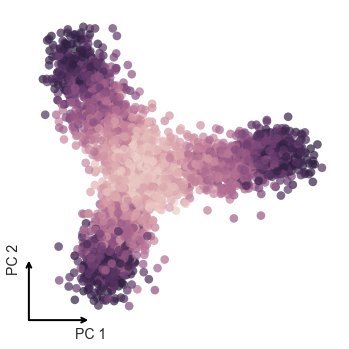

In [723]:
DR_plot(dim_name='PC').plot(sim_path.obsm['X_pca'], color=sim_path.obs['Step'])

In [724]:
%%time
# create neighborhood graphs from PCA results for UMAP
sc.pp.neighbors(sim_path, n_neighbors=50, use_rep='X', knn=True, random_state=11, metric='euclidean', copy=False)
# perform UMAP
sc.tl.umap(sim_path, random_state=18)

CPU times: user 7.35 s, sys: 181 ms, total: 7.53 s
Wall time: 6.21 s


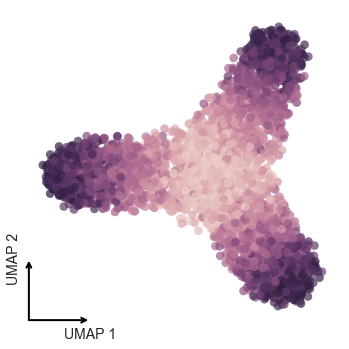

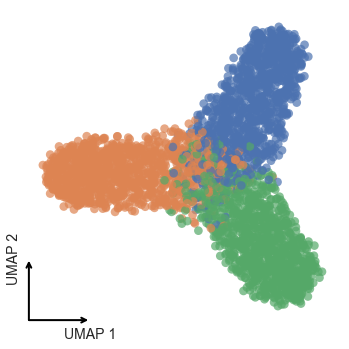

In [725]:
DR_plot(dim_name='UMAP').plot(sim_path.obsm['X_umap'], color=sim_path.obs['Step'])
DR_plot(dim_name='UMAP').plot(sim_path.obsm['X_umap'], color=sim_path.obs['Group'])

In [644]:
# perform t-SNE
%time sc.tl.tsne(sim_path, use_rep='X', perplexity=50, random_state=18)

CPU times: user 27 s, sys: 45.6 ms, total: 27.1 s
Wall time: 27.1 s


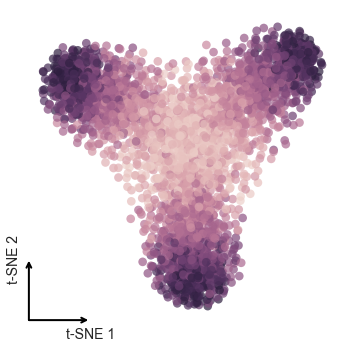

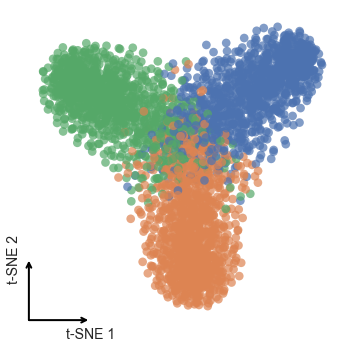

In [645]:
DR_plot(dim_name='t-SNE').plot(sim_path.obsm['X_tsne'], color=sim_path.obs['Step'])
DR_plot(dim_name='t-SNE').plot(sim_path.obsm['X_tsne'], color=sim_path.obs['Group'])

In [727]:
# turn PT values into .obsm as vertical vector
sim_path.obsm['pseudotime'] = sim_path.obs['Step'].values.reshape((sim_path.n_obs,1))

In [563]:
def pairwise_sums(v1, v2):
    out = np.repeat(v1, len(v2), axis=1) + np.repeat(v2, len(v1), axis=1).T
    return out.flatten()


def cluster_arrangement_PT(
    adata,
    post,
    obs_col,
    IDs,
    ID_names=None,
    figsize=(4, 4),
    legend=True,
    ax_labels=["Native", "Latent"],
):
    """
    determine pairwise distance preservation between 3 IDs from adata.obs[obs_col]
        adata = anndata object to pull dimensionality reduction from
        pre = matrix to subset as pre-transformation (i.e. adata.X)
        post = matrix to subset as pre-transformation (i.e. adata.obsm['X_pca'])
        obs_col = name of column in adata.obs to use as cell IDs (i.e. 'louvain')
        IDs = list of THREE IDs to compare (i.e. [0,1,2])
        figsize = size of resulting axes
        legend = display legend on plot
        ax_labels = list of two strings for x and y axis labels, respectively. if False, exclude axis labels.
    """
    # distance calculations for pre_obj
    dist_0_1 = pairwise_sums(adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[0]], adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[1]])
    dist_0_2 = pairwise_sums(adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[0]], adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[2]])
    dist_1_2 = pairwise_sums(adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[1]], adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[2]])
    # combine and min-max normalize
    dist = np.append(np.append(dist_0_1, dist_0_2), dist_1_2)
    dist = dist.astype(float)
    dist -= dist.min()
    dist /= dist.ptp()
    # split normalized distances by cluster pair
    dist_norm_0_1 = dist[: dist_0_1.shape[0]]
    dist_norm_0_2 = dist[dist_0_1.shape[0] : dist_0_1.shape[0] + dist_0_2.shape[0]]
    dist_norm_1_2 = dist[dist_0_1.shape[0] + dist_0_2.shape[0] :]

    # distance calculations for post_obj
    post_0_1 = cdist(
        post[adata.obs[obs_col] == IDs[0]], post[adata.obs[obs_col] == IDs[1]]
    ).flatten()
    post_0_2 = cdist(
        post[adata.obs[obs_col] == IDs[0]], post[adata.obs[obs_col] == IDs[2]]
    ).flatten()
    post_1_2 = cdist(
        post[adata.obs[obs_col] == IDs[1]], post[adata.obs[obs_col] == IDs[2]]
    ).flatten()
    # combine and min-max normalize
    post = np.append(np.append(post_0_1, post_0_2), post_1_2)
    post -= post.min()
    post /= post.ptp()
    # split normalized distances by cluster pair
    post_norm_0_1 = post[: post_0_1.shape[0]]
    post_norm_0_2 = post[post_0_1.shape[0] : post_0_1.shape[0] + post_0_2.shape[0]]
    post_norm_1_2 = post[post_0_1.shape[0] + post_0_2.shape[0] :]

    # calculate EMD and Pearson correlation stats
    EMD = [
        wasserstein_1d(dist_norm_0_1, post_norm_0_1),
        wasserstein_1d(dist_norm_0_2, post_norm_0_2),
        wasserstein_1d(dist_norm_1_2, post_norm_1_2),
    ]
    corr_stats = [
        pearsonr(x=dist_0_1, y=post_0_1)[0],
        pearsonr(x=dist_0_2, y=post_0_2)[0],
        pearsonr(x=dist_1_2, y=post_1_2)[0],
    ]

    if ID_names is None:
        ID_names = IDs.copy()

    # generate jointplot
    g = sns.JointGrid(x=dist, y=post, space=0, height=figsize[0])
    g.plot_joint(plt.hist2d, bins=50, cmap=sns.cubehelix_palette(as_cmap=True))
    sns.kdeplot(
        dist_norm_0_1,
        shade=False,
        bw=0.01,
        ax=g.ax_marg_x,
        color="darkorange",
        label=ID_names[0] + " - " + ID_names[1],
        legend=legend,
    )
    sns.kdeplot(
        dist_norm_0_2,
        shade=False,
        bw=0.01,
        ax=g.ax_marg_x,
        color="darkgreen",
        label=ID_names[0] + " - " + ID_names[2],
        legend=legend,
    )
    sns.kdeplot(
        dist_norm_1_2,
        shade=False,
        bw=0.01,
        ax=g.ax_marg_x,
        color="darkred",
        label=ID_names[1] + " - " + ID_names[2],
        legend=legend,
    )
    if legend:
        g.ax_marg_x.legend(loc=(1.01, 0.1))

    sns.kdeplot(
        post_norm_0_1,
        shade=False,
        bw=0.01,
        vertical=True,
        color="darkorange",
        ax=g.ax_marg_y,
    )
    sns.kdeplot(
        post_norm_0_2,
        shade=False,
        bw=0.01,
        vertical=True,
        color="darkgreen",
        ax=g.ax_marg_y,
    )
    sns.kdeplot(
        post_norm_1_2,
        shade=False,
        bw=0.01,
        vertical=True,
        color="darkred",
        ax=g.ax_marg_y,
    )
    g.ax_joint.plot(
        np.linspace(max(dist.min(), post.min()), 1, 100),
        np.linspace(max(dist.min(), post.min()), 1, 100),
        linestyle="dashed",
        color=sns.cubehelix_palette()[-1],
    )  # plot identity line as reference for regression
    if ax_labels:
        plt.xlabel(ax_labels[0], fontsize="xx-large", color=sns.cubehelix_palette()[-1])
        plt.ylabel(ax_labels[1], fontsize="xx-large", color=sns.cubehelix_palette()[2])

    plt.tick_params(labelleft=False, labelbottom=False)

    return corr_stats, EMD

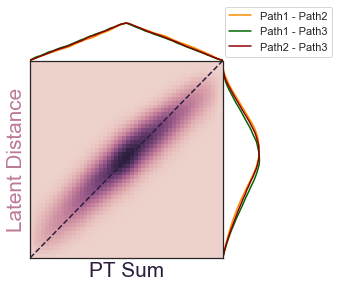

In [728]:
corr_stats_pca, EMD_pca = cluster_arrangement_PT(sim_path, post=sim_path.obsm["X_umap"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["PT Sum", "Latent Distance"])

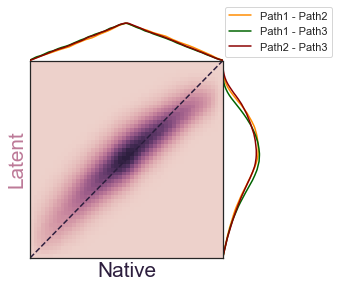

In [648]:
corr_stats_pca, EMD_pca = cluster_arrangement_PT(sim_path, post=sim_path.obsm["X_tsne"], obs_col="Group", IDs=["Path1","Path2","Path3"])

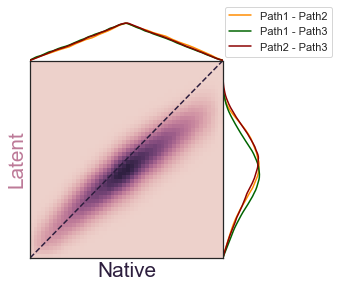

In [649]:
corr_stats_pca, EMD_pca = cluster_arrangement_PT(sim_path, post=sim_path.obsm["X_pca"], obs_col="Group", IDs=["Path1","Path2","Path3"])

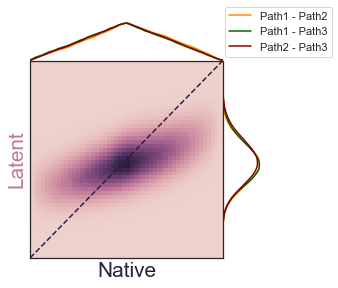

In [650]:
corr_stats_pca, EMD_pca = cluster_arrangement_PT(sim_path, post=sim_path.X, obs_col="Group", IDs=["Path1","Path2","Path3"])

---

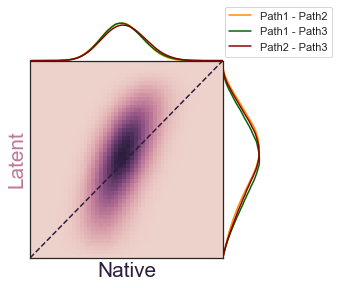

In [651]:
corr_stats_pca, EMD_pca = cluster_arrangement_sc(sim_path, pre=sim_path.X, post=sim_path.obsm["X_umap"], obs_col="Group", IDs=["Path1","Path2","Path3"])

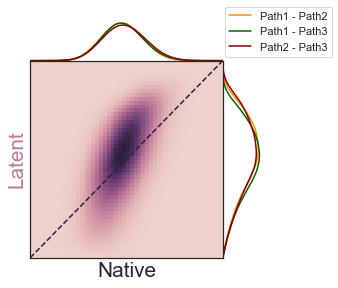

In [652]:
corr_stats_pca, EMD_pca = cluster_arrangement_sc(sim_path, pre=sim_path.X, post=sim_path.obsm["X_tsne"], obs_col="Group", IDs=["Path1","Path2","Path3"])

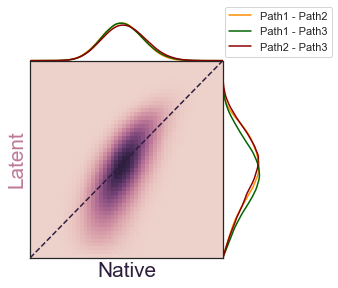

In [653]:
corr_stats_pca, EMD_pca = cluster_arrangement_sc(sim_path, pre=sim_path.X, post=sim_path.obsm["X_pca"], obs_col="Group", IDs=["Path1","Path2","Path3"])

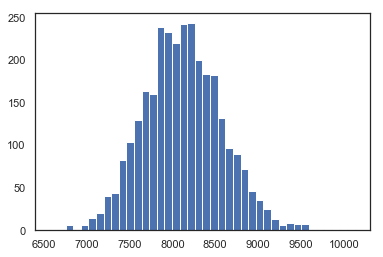

In [654]:
_ = plt.hist(sim_path.obs.total_counts, bins=40)

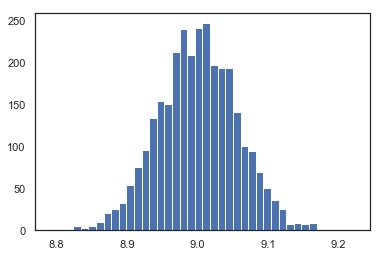

In [655]:
_ = plt.hist(sim_path.obs.log1p_total_counts, bins=40)

### Discrete data with directional pseudotime - three branches from middle

In [700]:
# get useful metrics of counts data
sc.pp.calculate_qc_metrics(sim_path_discrete, inplace=True)

# preprocess AnnData for downstream dimensionality reduction
sim_path_discrete.layers['raw_counts'] = sim_path_discrete.X.copy() # save raw counts in layer
sc.pp.normalize_total(sim_path_discrete, target_sum=None, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(sim_path_discrete, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
sim_path_discrete.X = sim_path_discrete.layers['arcsinh_norm'].copy()

# see resulting AnnData contents
sim_path_discrete

AnnData object with n_obs × n_vars = 1873 × 500 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'Step', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'norm_factor'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [701]:
sim_path_discrete.obs.Group.value_counts()

Path2    660
Path1    623
Path3    590
Name: Group, dtype: int64

In [575]:
p1_i = np.random.choice(sim_path_discrete.obs_names[sim_path_discrete.obs.Group=="Path1"], 840)
p2_i = np.random.choice(sim_path_discrete.obs_names[sim_path_discrete.obs.Group=="Path2"], 840)
p3_i = np.random.choice(sim_path_discrete.obs_names[sim_path_discrete.obs.Group=="Path3"], 840)

In [576]:
sim_path_discrete = sim_path_discrete[np.append(p1_i, (p2_i, p3_i)),:]
sim_path_discrete

View of AnnData object with n_obs × n_vars = 2520 × 500 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'Step', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'norm_factor'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [702]:
# perform PCA
%time sc.tl.pca(sim_path_discrete, n_comps=2)

CPU times: user 53.1 ms, sys: 47.2 ms, total: 100 ms
Wall time: 12.3 ms


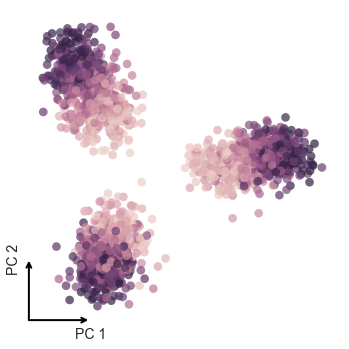

In [703]:
DR_plot(dim_name='PC').plot(sim_path_discrete.obsm['X_pca'], color=sim_path_discrete.obs['Step'])

In [704]:
%%time
# create neighborhood graphs from PCA results for UMAP
sc.pp.neighbors(sim_path_discrete, n_neighbors=30, use_rep='X', knn=True, random_state=11, metric='euclidean', copy=False)
# perform UMAP
sc.tl.umap(sim_path_discrete, random_state=18)

CPU times: user 4.03 s, sys: 142 ms, total: 4.17 s
Wall time: 3.17 s


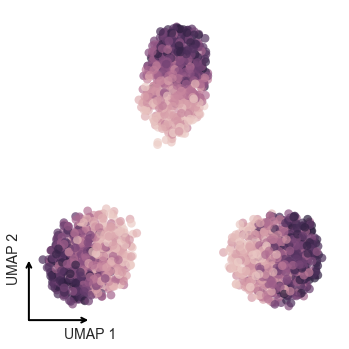

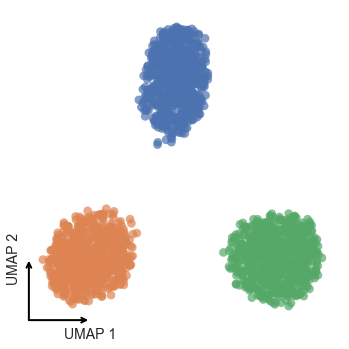

In [705]:
DR_plot(dim_name='UMAP').plot(sim_path_discrete.obsm['X_umap'], color=sim_path_discrete.obs['Step'])
DR_plot(dim_name='UMAP').plot(sim_path_discrete.obsm['X_umap'], color=sim_path_discrete.obs['Group'])

In [706]:
# perform t-SNE
%time sc.tl.tsne(sim_path_discrete, use_rep='X', perplexity=30, random_state=18)

CPU times: user 12.8 s, sys: 5.86 ms, total: 12.8 s
Wall time: 12.8 s


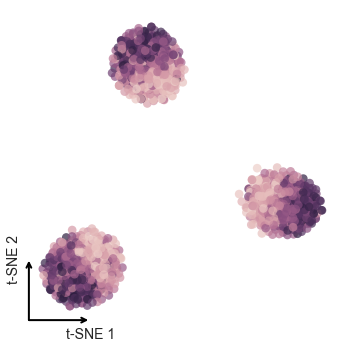

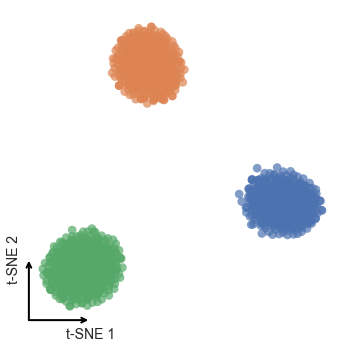

In [707]:
DR_plot(dim_name='t-SNE').plot(sim_path_discrete.obsm['X_tsne'], color=sim_path_discrete.obs['Step'])
DR_plot(dim_name='t-SNE').plot(sim_path_discrete.obsm['X_tsne'], color=sim_path_discrete.obs['Group'])

In [708]:
# turn PT values into .obsm as vertical vector
sim_path_discrete.obsm['pseudotime'] = sim_path_discrete.obs['Step'].values.reshape((sim_path_discrete.n_obs,1))

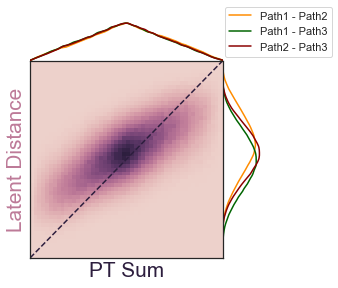

In [729]:
corr_stats_pca, EMD_pca = cluster_arrangement_PT(sim_path_discrete, post=sim_path_discrete.obsm["X_umap"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["PT Sum", "Latent Distance"])

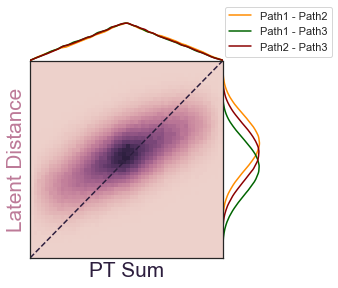

In [730]:
corr_stats_pca, EMD_pca = cluster_arrangement_PT(sim_path_discrete, post=sim_path_discrete.obsm["X_tsne"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["PT Sum", "Latent Distance"])

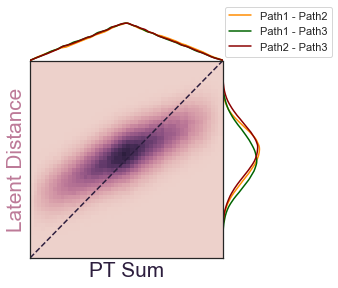

In [731]:
corr_stats_pca, EMD_pca = cluster_arrangement_PT(sim_path_discrete, post=sim_path_discrete.obsm["X_pca"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["PT Sum", "Latent Distance"])

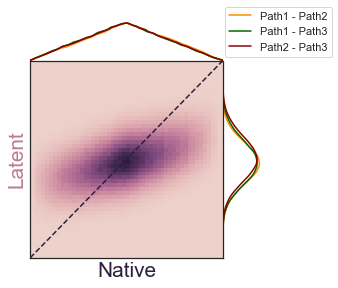

In [712]:
corr_stats_pca, EMD_pca = cluster_arrangement_PT(sim_path_discrete, post=sim_path_discrete.X, obs_col="Group", IDs=["Path1","Path2","Path3"])

---

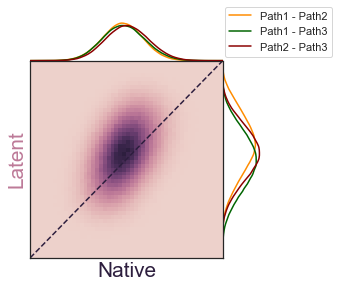

In [713]:
corr_stats_pca, EMD_pca = cluster_arrangement_sc(sim_path_discrete, pre=sim_path_discrete.X, post=sim_path_discrete.obsm["X_umap"], obs_col="Group", IDs=["Path1","Path2","Path3"])

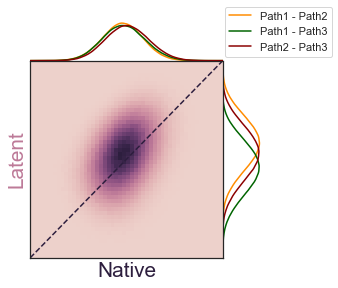

In [714]:
corr_stats_pca, EMD_pca = cluster_arrangement_sc(sim_path_discrete, pre=sim_path_discrete.X, post=sim_path_discrete.obsm["X_tsne"], obs_col="Group", IDs=["Path1","Path2","Path3"])

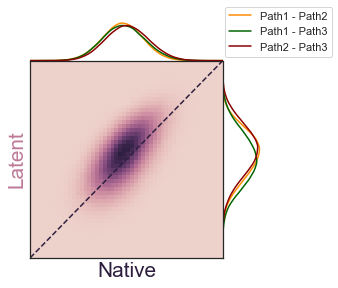

In [715]:
corr_stats_pca, EMD_pca = cluster_arrangement_sc(sim_path_discrete, pre=sim_path_discrete.X, post=sim_path_discrete.obsm["X_pca"], obs_col="Group", IDs=["Path1","Path2","Path3"])

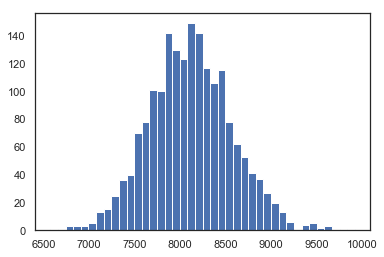

In [716]:
_ = plt.hist(sim_path_discrete.obs.total_counts, bins=40)

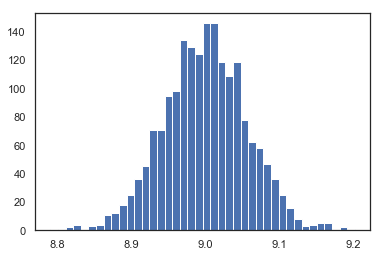

In [717]:
_ = plt.hist(sim_path_discrete.obs.log1p_total_counts, bins=40)